# Building LSTM Networks using Keras
---

# Introduction

In this notebook, we will discover the world of LSTM through Keras. 


## Why Keras?

Because it was one of the first open-soruce python library to provide LSTM networks in its collection along **Lasagne** and **Block**. **Caffee** added it later on (2015).

It is built on top of **TensorFlow**, **CNTK**, or **Theano**, and hence is pretty effective.


## Other libraries

We will also use tools from the following libraries:
- matplotlib
- numpy
- sckitlearn
- tensorflow


## Sources

Here is a bunch of good lectures / videos about LSTM / RNN:
- (rrn overview) https://ayearofai.com/rohan-lenny-3-recurrent-neural-networks-10300100899b
- (music generation) https://www.youtube.com/watch?v=aSr8_QQYpYM + https://drive.google.com/file/d/0B7oYxDkqYqqPYlR2LU01LVktbUU/view
- (examples) http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


## Data

- nottingham.txt: http://abc.sourceforge.net/NMD/nmd/jigs.txt


---

# Data

We want to be able to forecast the number a passengers.

In [1]:
import pandas
import matplotlib.pyplot as plt

In [2]:
path = "data/international-airline-passengers.csv"

# Display tail of file
with open(path) as file:
    print("".join(file.readlines()[:10]))

"Month","passengers (thousands)"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
"1949-06",135
"1949-07",148
"1949-08",148
"1949-09",136



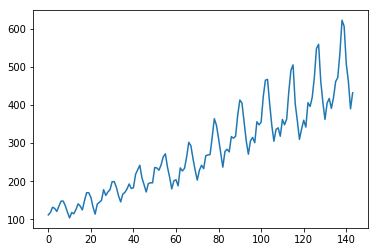

In [3]:
dataframe = pandas.read_csv(path, usecols=[1], engine='python', skipfooter=3)
plt.plot(dataframe)
plt.show()

---

# LSTM - Tools

## Preparing preprocessing

In [4]:
import numpy as np


def create_XY(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_sets(dataframe, scaler, ratio=0.67, look_back=1, input_type='simultaneous'):

    # Create dataset
    dataset = dataframe.values.astype('float32')

    # Normalize
    ds = scaler.fit_transform(dataset)

    # Split dataset in train, test
    train_size = int(len(ds) * ratio)
    train, test = ds[0:train_size, :], ds[train_size:len(dataset), :]

    # Reshape data
    trainX, trainY = create_XY(train, look_back)
    testX, testY = create_XY(test, look_back)

    # Reshape input to be [samples, time steps, features]
    if input_type is 'simultaneous':
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    elif input_type is 'sequential':
        trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
        testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    else:
        raise ValueError(
            "Input type can be 'sequential' or 'simultaneous', got %s"
            % input_type
        )
        
    return ds, trainX, trainY, testX, testY


## Model

In [5]:
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


def create_LSTM(input_shape, look_back, stateful, batch_size, layers):
    model = Sequential()
    for layer_i in range(layers):
        if layer_i < layers - 1:
            return_sequences = True
        else:
            return_sequences = False
        model.add(
            LSTM(
                4,
                batch_input_shape=(batch_size, input_shape[0], input_shape[1]),
                stateful=stateful,
                return_sequences=return_sequences,
            )
        )
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Using TensorFlow backend.


## Testing

In [6]:
def test(model, scaler, trainX, trainY, testX, testY, batch_size):
    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainPredict, testPredict


def display(ds, trainPredict, testPredict, scaler, look_back):
    # Show results

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(ds)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(ds)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict

    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(ds))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

## Run all

In [7]:
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping

def run(dataframe, look_back, input_type='simultaneous', stateful=False, layers=1, verbose=0):
    
    np.random.seed(7)
    batch_size = 1
    
    # Setting things up
    scaler = MinMaxScaler(feature_range=(0, 1))
    ds, trainX, trainY, testX, testY = create_sets(
        dataframe,
        scaler,
        look_back=look_back,
        input_type=input_type,
    )
    
    print("Input shape:", trainX.shape[1:])

    if input_type is 'simultaneous':
        input_shape = (1, look_back)
    elif input_type is 'sequential':
        input_shape = (look_back, 1)
    else:
        raise ValueError(
            "Input type can be 'sequential' or 'simultaneous', got %s"
            % input_type
        )
    model = create_LSTM(input_shape, look_back=look_back, stateful=stateful, batch_size=batch_size, layers=layers)
    
    # Training
    try:
        epochs = 100
        if stateful:
            for i in range(epochs):
                hist = model.fit(
                    trainX,
                    trainY,
                    epochs=1,
                    batch_size=1,
                    verbose=0,
                    shuffle=False,
                )
                model.reset_states()
                if verbose:
                    epoch_msg = "Epoch %s / %s" % (i+1, epochs)
                    loss_msg = "loss  %.3e" % hist.history['loss'][0]
                    print("%s   %s" % (epoch_msg, loss_msg), end="\r")
            if verbose:
                print()
        else:
            # earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')
            model.fit(
                trainX,
                trainY,
                epochs=epochs,
                batch_size=batch_size,
                # callbacks=[earlystop],
                verbose=verbose,
            )
    except KeyboardInterrupt:
        pass
    
    trainPredict, testPredict = test(model, scaler, trainX, trainY, testX, testY, batch_size=batch_size)
    display(ds, trainPredict, testPredict, scaler, look_back)
    
    return {
        'scaler': scaler,
        'ds': ds,
        'trainX': trainX,
        'trainY': trainY,
        'testX': testX,
        'testY': testY,
        'input_shape': input_shape,
        'model': model,
        'trainPredict': trainPredict,
        'testPredict': testPredict,
        'batch_size': batch_size,
    }

# Tests

## Regression

> **one to one** RNN with **scalar input**

Input shape: (1, 1)
Train Score: 22.93 RMSE
Test Score: 47.53 RMSE


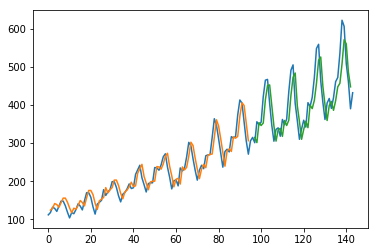

In [8]:
_ = run(dataframe, look_back=1)

## Regression with Window Method

> **one to one** RNN with **vector input**

Input shape: (1, 3)
Train Score: 24.19 RMSE
Test Score: 58.04 RMSE


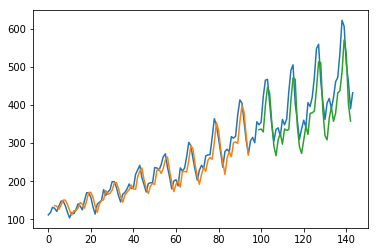

In [9]:
_ = run(dataframe, look_back=3)

## Regression with time step
> **many to one** RNN with **scalar input**

Input shape: (3, 1)
Train Score: 23.69 RMSE
Test Score: 58.95 RMSE


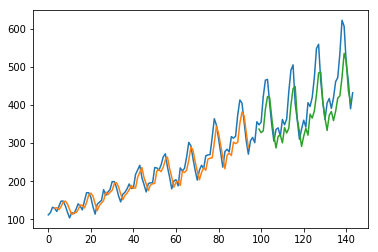

In [10]:
_ = run(dataframe, look_back=3, input_type='sequential')

## Memory Between Batches

Input shape: (3, 1)
Train Score: 20.74 RMSE
Test Score: 50.72 RMSE


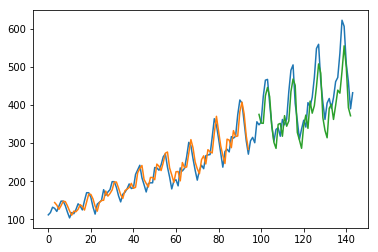

In [11]:
_ = run(dataframe, look_back=3, input_type='sequential', stateful=True)

## Stacked LSTM

Input shape: (3, 1)
Train Score: 20.49 RMSE
Test Score: 54.87 RMSE


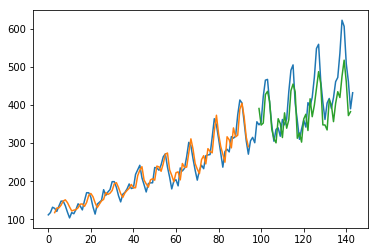

In [12]:
_ = run(dataframe, look_back=3, input_type='sequential', stateful=True, layers=2)

---
# Play with results

In [8]:
import matplotlib.pyplot as plt

def forecast(res):
    model = res['model']
    ds = res['ds']
    trainX = res['trainX']
    batch_size = res['batch_size']

    # Make predictions starting with first vector
    look_ahead = 130
    batch = trainX[0]
    predictions = []
    for i in range(look_ahead):
        prediction = model.predict(np.array([batch]), batch_size=batch_size)
        batch = np.array(list(batch[1:]) + [prediction[0]])

        # prediction = scaler.inverse_transform(prediction)
        predictions.append(prediction[0, 0])
    predictions = np.array(list(trainX[0, :, 0]) + predictions)

    # Display Predictions
    plt.plot(predictions, label="predictions")
    plt.plot(ds[:, 0], label="expected")
    plt.legend()
    plt.show()


Input shape: (20, 1)
Epoch 100 / 100   loss  1.719e-03
Train Score: 20.35 RMSE
Test Score: 38.42 RMSE


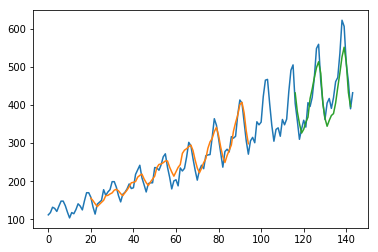

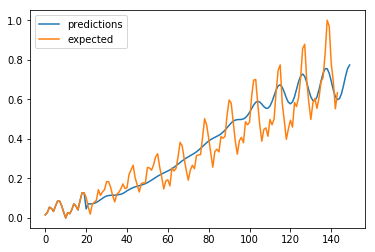

In [14]:
res = run(dataframe, look_back=20, input_type='sequential', stateful=True, verbose=1)
forecast(res)

Input shape: (10, 1)
Epoch 100 / 100   loss  1.819e-03
Train Score: 21.78 RMSE
Test Score: 56.30 RMSE


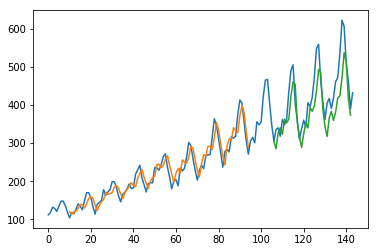

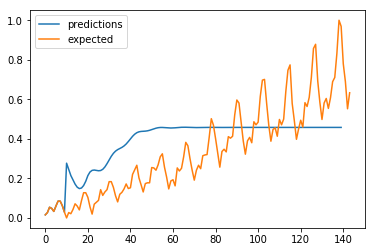

In [15]:
res = run(dataframe, look_back=10, input_type='sequential', stateful=True, verbose=1)
forecast(res)

---

# Save & Load

## Save

In [9]:
import json
import os
from numpy import array, ndarray
from pprint import pprint

def to_json(dic):
    """Return reworked dictionnary writtable into json."""
    res = {}
    for key, value in dic.items():
        if isinstance(value, dict):
            res[key] = to_json(value)
        elif isinstance(value, ndarray):
            res[key] = list(map(float, value))
        else:
            res[key] = value
    return res


def save_scaler(scaler, path):
    """Save revelant informations about scaler at path."""
    description = dict([
        ('params', scaler.get_params()),
        ('kwargs', scaler.__dict__),
        ('cls_name', scaler.__class__.__name__),
    ])
    with open(path, 'w') as outfile:
        json.dump(to_json(description), outfile)
    json.dumps(path, description)


def save(model, scaler, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # Save model
    path = os.path.join(directory, 'model.h5')
    model.save(path)
    print("Model saved at '%s'" % path)
    
    # Save scaler
    path = os.path.join(directory, 'scaler.json')
    save_scaler(scaler, path)
    print("Scaler description saved at '%s'" % path)


Input shape: (20, 1)
Epoch 100 / 100   loss  1.720e-03
Train Score: 20.35 RMSE
Test Score: 38.53 RMSE


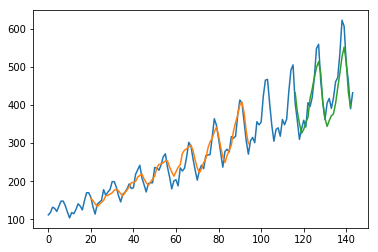

In [10]:
res = run(dataframe, look_back=20, input_type='sequential', stateful=True, verbose=1)

In [14]:
save(res['model'], res['scaler'], directory="results\\sequential_20_stateful")

Model saved at 'results\sequential_20_stateful\model.h5'
Scaler description saved at 'results\sequential_20_stateful\scaler.json'


## Load


It is tricky to reuse a model because we have to remember the preprocessing:

SOURCE **--select->** Xsource **--rescale->** Xr **--vectorize->** Xv **--reshape->** X

We need to remember all those steps. Meaning:
- How data is selected from source
- What are the scalers (for X and Y)
- How is input is vectorized (in what order lists are concatenate to create features)
- What is the shape of the input: number of time steps, number of features.


In [15]:
import importlib
import json
import numpy as np
import pandas
import os
import sklearn.preprocessing as scalers

from keras.models import load_model
from numpy import array


def to_keras(dic):
    """Build dict with numpy arrays instead of lists."""
    res = {}
    for key, value in dic.items():
        if isinstance(value, dict):
            res[key] = to_keras(value)
        elif isinstance(value, list):
            res[key] = array(value)
        else:
            res[key] = value
    return res


def load_scaler(path):
    """Create scaler described at path"""
    # Read scaler description from file
    with open(path) as file:
        scaler_descr = json.load(file)
    scaler_descr = to_keras(scaler_descr)
    cls_name = scaler_descr['cls_name']
    params = scaler_descr['params']
    kwargs = scaler_descr['kwargs']
    
    # Create scaler given description
    scaler = getattr(scalers, cls_name)(**params)
    scaler.__dict__.update(**kwargs)
    return scaler


def load(directory):
    
    def path(file_name):
        return os.path.join(directory, file_name)
    
    model = load_model(path("model.h5"))
    scaler = load_scaler(path("scaler.json"))
    
    return {
        'model': model,
        'scaler': scaler,
    }

In [16]:
# Load model

loaded = load("results\sequential_20_stateful")
model = loaded['model']
scaler = loaded['scaler']

In [17]:
# Load data

path = "data/international-airline-passengers.csv"
dataframe = pandas.read_csv(path, usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values.astype('float32')

In [18]:
# Rescale

ds = scaler.transform(dataset)

In [19]:
# Reshape and create both X and Y
n, _ = ds.shape
batch_size, timesteps, features = model.input_shape

dataX, dataY = [], []
look_back = timesteps * features

for i in range(n - look_back - 1):
    # X, last <look_back> values
    a = ds[i:(i + look_back), 0]
    a = a.reshape(timesteps, features)
    dataX.append(a)
    
    # Y, next value
    dataY.append([dataset[i + look_back, 0]])
dataX, dataY = np.array(dataX), np.array(dataY)


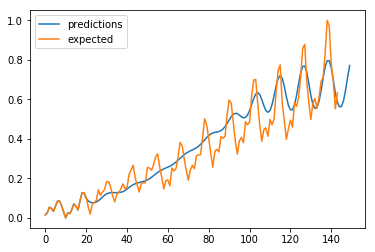

In [20]:
# Try to forcast
res = {
    'model': model,
    'ds': ds,
    'trainX': dataX,
    'batch_size': batch_size,
}
forecast(res)